
# Ask Syracuse Data ? Exploratory Analysis
Phase 2 exploratory notebook for Syracuse housing and public safety datasets. Focused on reproducible visuals, summary stats, and simple cross-dataset checks.



## Goals
- Load cleaned CSV snapshots using shared utilities.
- Produce temporal and geographic visuals for violations, vacancies, rentals, and crime.
- Compare overlaps across datasets (SBL-based where available).
- Keep outputs deterministic; all figures use static CSV inputs.


In [12]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from data_utils import (
    load_code_violations,
    load_rental_registry,
    load_vacant_properties,
    load_crime_2022,
    summarize_nulls,
    drop_outside_bounds,
)

pd.set_option("display.max_columns", 50)
sns.set_theme(style="whitegrid")
plt.rcParams.update({"figure.figsize": (8, 4)})


In [13]:

# Load datasets (uses local CSV snapshots)
violations = load_code_violations("Code_Violations_V2.csv")
rental = load_rental_registry("Syracuse_Rental_Registry.csv")
vacant = load_vacant_properties("Vacant_Properties.csv")
crime = load_crime_2022("Crime_Data_2022_(Part_1_Offenses).csv")

print("Loaded:")
print(f"- Code violations: {violations.shape}")
print(f"- Rental registry: {rental.shape}")
print(f"- Vacant properties: {vacant.shape}")
print(f"- Crime 2022: {crime.shape}")


Loaded:
- Code violations: (137663, 28)
- Rental registry: (11085, 22)
- Vacant properties: (1651, 17)
- Crime 2022: (5660, 11)


c:\Users\prath\OneDrive\Desktop\RA work\RA9\data_utils.py:71: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df[f"{date_col}_period"] = df[date_col].dt.to_period("M").astype(str)
c:\Users\prath\OneDrive\Desktop\RA work\RA9\data_utils.py:71: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df[f"{date_col}_period"] = df[date_col].dt.to_period("M").astype(str)


In [14]:

# Quick schema + missingness review
for name, df in {
    "Violations": violations,
    "Rental": rental,
    "Vacant": vacant,
    "Crime": crime,
}.items():
    print(f"{name} columns: {list(df.columns)}")
    display(summarize_nulls(df).head())


Violations columns: ['x', 'y', 'sbl', 'complaint_address', 'complaint_zip', 'complaint_number', 'complaint_type_name', 'violation_id', 'open_date', 'violation_number', 'violation', 'violation_date', 'comply_by_date', 'status_type_name', 'status_date', 'issued_to', 'issued_to_address', 'issued_to_city', 'issued_to_zip', 'inspector_id', 'neighborhood', 'vacant', 'latitude', 'longitude', 'objectid', 'violation_date_year', 'violation_date_month', 'violation_date_period']


,column,missing,non_missing,pct_missing
0,x,49,137614,0.04
1,y,49,137614,0.04
2,sbl,0,137663,0.00
3,complaint_address,0,137663,0.00
4,complaint_zip,0,137663,0.00


Rental columns: ['x', 'y', 'sbl', 'propertyaddress', 'zip', 'needsrr', 'inspect_period', 'completion_type_name', 'completion_date', 'valid_until', 'rrisvalid', 'rr_app_received', 'rr_ext_insp_pass', 'rr_ext_insp_fail', 'rr_int_insp_fail', 'rr_int_insp_pass', 'rr_contact_name', 'pc_owner', 'latitude', 'longitude', 'shape', 'objectid']


,column,missing,non_missing,pct_missing
0,x,256,10829,2.31
1,y,256,10829,2.31
2,sbl,0,11085,0.00
3,propertyaddress,0,11085,0.00
4,zip,0,11085,0.00


Vacant columns: ['x', 'y', 'sbl', 'propertyaddress', 'zip', 'owner', 'owneraddress', 'vacant', 'neighborhood', 'vpr_result', 'completion_date', 'completion_type_name', 'valid_until', 'vpr_valid', 'latitude', 'longitude', 'objectid']


,column,missing,non_missing,pct_missing
0,x,36,1615,2.18
1,y,36,1615,2.18
2,sbl,0,1651,0.00
3,propertyaddress,0,1651,0.00
4,zip,0,1651,0.00


Crime columns: ['dateend', 'timestart', 'timeend', 'address', 'code_defined', 'arrest', 'larcenycode', 'objectid', 'dateend_year', 'dateend_month', 'dateend_period']


,column,missing,non_missing,pct_missing
0,dateend,0,5660,0.0
1,timestart,0,5660,0.0
2,timeend,0,5660,0.0
3,address,0,5660,0.0
4,code_defined,0,5660,0.0



## Temporal trends
Monthly counts for code violations and Part 1 crimes (2022 snapshot only).


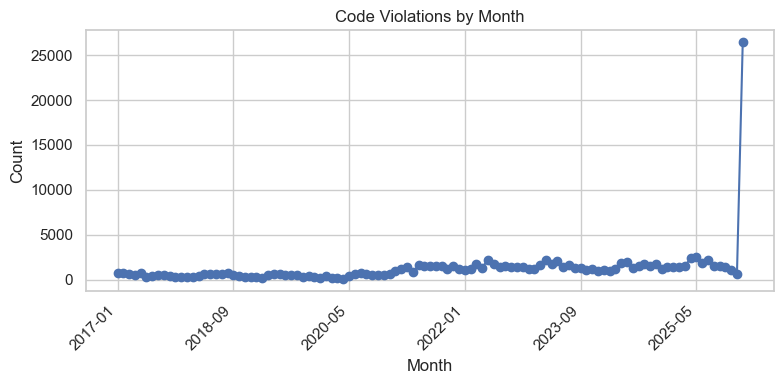

In [15]:

# Code violations by month
viol_month = (
    violations.dropna(subset=["violation_date_period"])
    .groupby("violation_date_period")
    .size()
    .sort_index()
)
ax = viol_month.plot(kind="line", marker="o")
ax.set_title("Code Violations by Month")
ax.set_xlabel("Month")
ax.set_ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


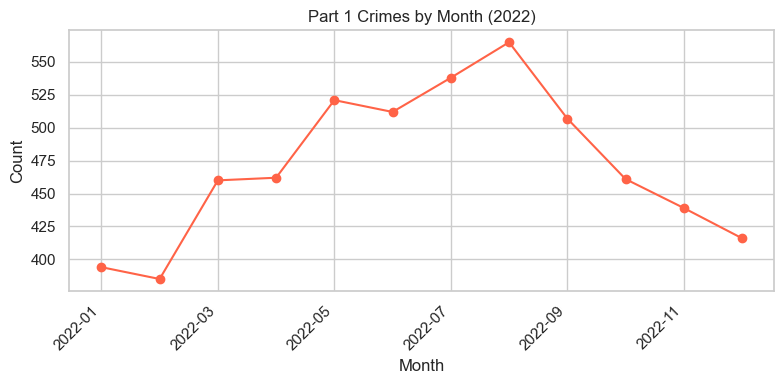

In [16]:

# Part 1 crimes by month (2022)
crime_month = (
    crime.dropna(subset=["dateend_period"])
    .groupby("dateend_period")
    .size()
    .sort_index()
)
ax = crime_month.plot(kind="line", color="tomato", marker="o")
ax.set_title("Part 1 Crimes by Month (2022)")
ax.set_xlabel("Month")
ax.set_ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()



## Offense and violation mix
Top categories to identify concentration areas.


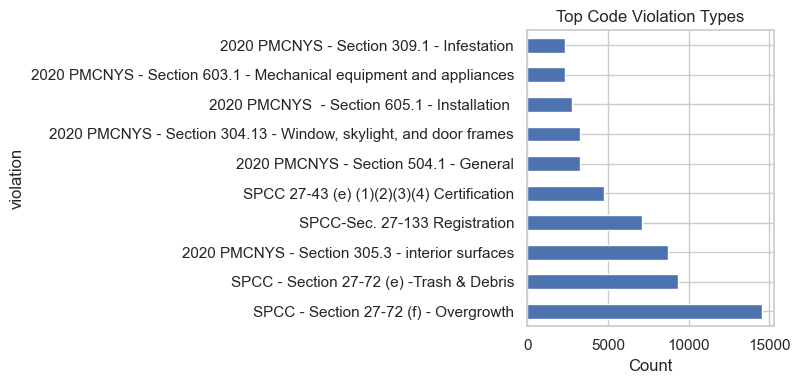

In [17]:

# Top 10 code violation types
viol_types = violations["violation"].value_counts().head(10)
ax = viol_types.plot(kind="barh")
ax.set_title("Top Code Violation Types")
ax.set_xlabel("Count")
plt.tight_layout()
plt.show()


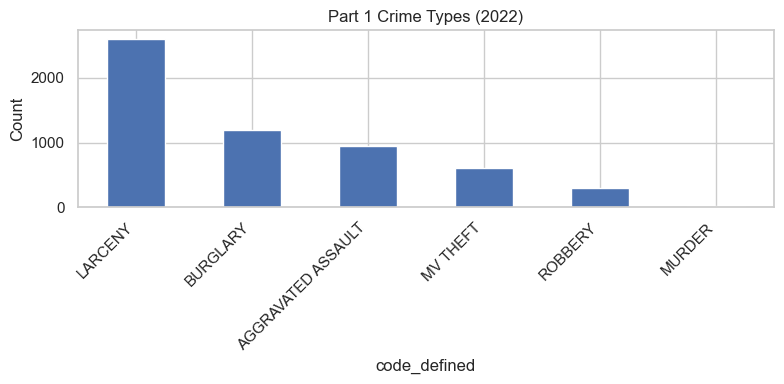

In [18]:

# Crime offense distribution
crime_types = crime["code_defined"].value_counts()
ax = crime_types.plot(kind="bar")
ax.set_title("Part 1 Crime Types (2022)")
ax.set_ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()



## Vacancy and rental status
Registry validity and spatial distribution snapshots.


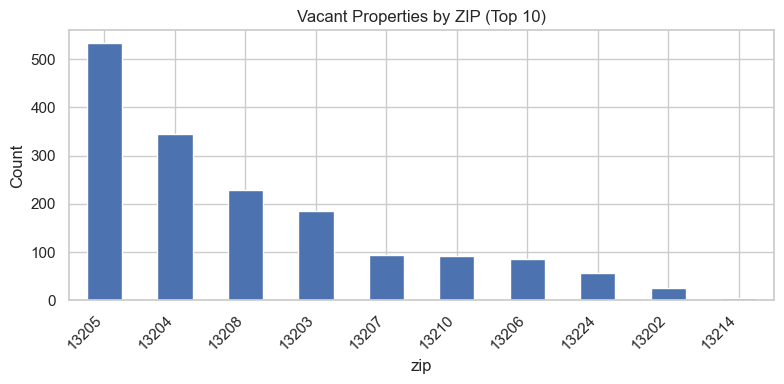

In [19]:

# Vacant properties by ZIP (top 10)
vacant_zip = vacant["zip"].value_counts().head(10)
ax = vacant_zip.plot(kind="bar")
ax.set_title("Vacant Properties by ZIP (Top 10)")
ax.set_ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


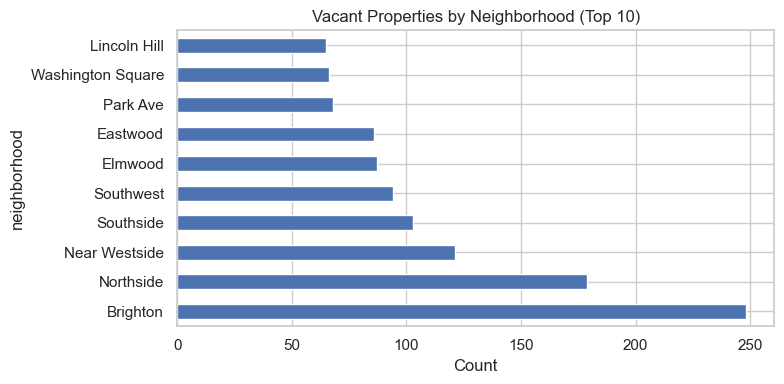

In [20]:

# Vacant properties by neighborhood (top 10)
vacant_nbhd = vacant["neighborhood"].value_counts().head(10)
ax = vacant_nbhd.plot(kind="barh")
ax.set_title("Vacant Properties by Neighborhood (Top 10)")
ax.set_xlabel("Count")
plt.tight_layout()
plt.show()


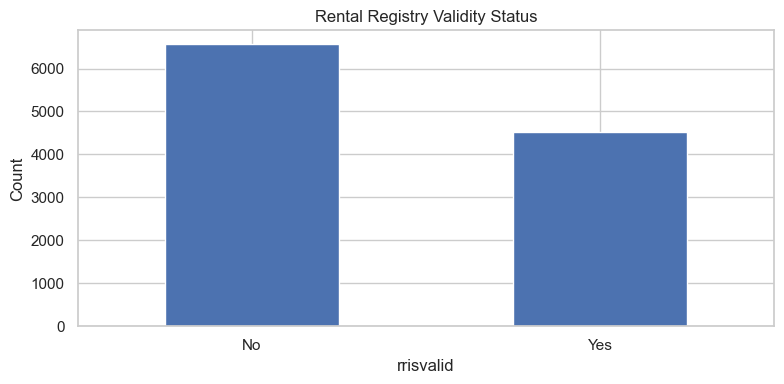

In [21]:

# Rental registry validity status
rr_valid = rental["rrisvalid"].value_counts(dropna=False)
ax = rr_valid.plot(kind="bar")
ax.set_title("Rental Registry Validity Status")
ax.set_ylabel("Count")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()



## Cross-dataset relationships (descriptive)
SBL-based overlap between vacancies, rentals, and code violations. This is descriptive only and does not imply causality.


In [ ]:

# SBL overlap counts
viol_sbl = set(violations["sbl"].dropna())
vac_sbl = set(vacant["sbl"].dropna())
rr_sbl = set(rental["sbl"].dropna())

print("SBL counts:")
print(f"- Violations SBLs: {len(viol_sbl)}")
print(f"- Vacant SBLs: {len(vac_sbl)}")
print(f"- Rental SBLs: {len(rr_sbl)}")

print("Overlaps:")
print(f"- Vacant ? Violations: {len(vac_sbl & viol_sbl)}")
print(f"- Rental ? Violations: {len(rr_sbl & viol_sbl)}")
print(f"- Vacant ? Rental: {len(vac_sbl & rr_sbl)}")


In [ ]:

# Open violations on vacant properties (counts only)
vacant_flag = violations["vacant"].notna() if "vacant" in violations.columns else pd.Series(False, index=violations.index)
open_flag = violations["status_type_name"].str.contains("open", case=False, na=False)

summary = pd.crosstab(open_flag, vacant_flag, rownames=["open_violation"], colnames=["listed_vacant"])
print(summary)



## Notes and limitations
- Static CSV snapshots only; no live updates.
- Crime data limited to Part 1 offenses in 2022.
- SBL overlaps are approximate; missing or malformed SBLs reduce linkage counts.
- Descriptive only?no causal inference or predictive modeling.
